In [1]:
import numpy as np
from matplotlib import pyplot as plt

from data_generation import Three_body_2D_Rick
from data_generation import tbp_util
from data_generation.tbp_energy_calculations import visualize_dataset

# validation

This file should contain just enough information to load training data and evaluate saved models.
Still only a stub. The goal is to have validation against a precise dataset.



In [2]:
# not up to date!
experiments = {
    "Experiment_2": {
        "max_datasets": 2,
        "prediction_offset": 10,  # predict t time steps ahead
        "batch_size": 256,
        "epochs": 20,
        "validation_split": 0.1,
        "no_dense_layers": 10,
        "neurons_per_layer": 128,
        "learning_rate": 0.0001,
        "dataset": {
            "name": "breen-et-al-00001",
            # filter 1 in 10 values to reduce RAM usage
            "downsample_factor": 10,
            "dataset_index": 1,
            "delta_scaling_factor": 10000
        }
    },
    "Experiment_2_1": {
        "max_datasets": 2,
        "prediction_offset": 10,  # predict t time steps ahead
        "batch_size": 256,
        "epochs": 20,
        "validation_split": 0.1,
        "no_dense_layers": 10,
        "neurons_per_layer": 128,
        "learning_rate": 0.00001,
        "dataset": {
            "name": "breen-et-al-00001",
            # filter 1 in 10 values to reduce RAM usage
            "downsample_factor": 10,
            "dataset_index": 2,
            "delta_scaling_factor": 10000
        }
    },
}

In [3]:
experiment_id = "Experiment_2_1"
config_name = experiments[experiment_id]["dataset"]["name"]
tbp_util.use_config(config_name)

Setting breen-et-al-00001 as the configuration to load trajectories from


In [4]:
# allow autoreloading of imported modules whenever running a cell
# if not included, a kernel restart is needed whenever one of the imports is modified
# (Needs experimenting / import statements to work)
# %load_ext autoreload
# %autoreload 2

In [5]:
# todo read from config file
# also see tbp_util.py
G = 1.0
M = np.array([1.0, 1.0, 1.0])

# deltas

In [6]:
def get_deltas(x, y, vx, vy, delta=1, scaling_factor=1):
    dx = (x[:-delta] - x[delta:]) * scaling_factor
    dy = (y[:-delta] - y[delta:]) * scaling_factor
    dvx = (vx[:-delta] - vx[delta:]) * scaling_factor
    dvy = (vy[:-delta] - vy[delta:]) * scaling_factor
    return dx, dy, dvx, dvy


In [7]:
from tensorflow import keras

keras.backend.set_floatx('float64')
keras.backend.floatx()

2023-07-01 20:58:02.174323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'float64'

# Load training data

Load training data.
A trajectory has t timesteps. For each time step it has 12 variables:
- x, y, vx, vy for each of the 3 bodies

max_datasets: maximum number of datasets to load and train on
prediction offset: how many time steps to predict into the future
downsample factor: only use one in downsample_factor data points for training, allows for k-partition validation
dataset_index: if using a downsample factor of 10, there are 10 unique sub-datasets that can be used

In [8]:
max_datasets = experiments[experiment_id]['max_datasets']
prediction_offset = experiments[experiment_id]['prediction_offset']
downsample_factor = experiments[experiment_id]['dataset']['downsample_factor']
dataset_index = experiments[experiment_id]['dataset']['dataset_index']
scaling_factor = experiments[experiment_id]['dataset']['delta_scaling_factor']

x_train = np.ndarray((0, 12), dtype=np.float64)
y_train = np.ndarray((0, 12), dtype=np.float64)
for dataset, x, y, vx, vy in tbp_util.load_datasets(limit=max_datasets):
    print(dataset)
    x = x[dataset_index:, :]
    y = y[dataset_index:, :]
    vx = vx[dataset_index:, :]
    vy = vy[dataset_index:, :]

    input_data = np.column_stack((x, y, vx, vy))
    input_data = input_data[:-prediction_offset:downsample_factor, :]

    deltas = get_deltas(x, y, vx, vy, delta=prediction_offset, scaling_factor=scaling_factor)
    output_data = np.column_stack(deltas)[::downsample_factor, :]

    x_train = np.concatenate((x_train, input_data))
    y_train = np.concatenate((y_train, output_data))


68
168
loaded 0 datasets


In [9]:
x_train.shape

(49998, 12)

In [10]:
y_train.shape

(49998, 12)

In [11]:
assert x_train.shape == y_train.shape

first training example **[ x1, x2, x3, y1, y2, y3, vx1, vx2, vx3, vy1, vy2, vy3 ]**
first testing  example **[ x1', x2', x3', y1', y2', y3', vx1', vx2', vx3', vy1', vy2', vy3' ]**

In [12]:
x_train[0,]

array([ 1.00000000e+00, -1.27078224e-01, -8.72921776e-01,  1.33540014e-11,
        2.69868627e-01, -2.69868627e-01, -2.00096688e-05, -4.63457586e-06,
        2.46442446e-05,  2.67080029e-06, -1.73007262e-05,  1.46299259e-05],
      dtype=float128)

In [13]:
y_train[0,]

array([ 6.50314236e-05,  1.50623717e-05, -8.00937953e-05, -8.68010091e-06,
        5.62273603e-05, -4.75472594e-05,  1.00048344e+00,  2.31728800e-01,
       -1.23221224e+00, -1.33540014e-01,  8.65036316e-01, -7.31496303e-01],
      dtype=float128)

In [14]:
import os

model_id = f'{experiment_id}-{config_name}'
model_path = f'./models/{experiment_id}/{config_name}'
os.makedirs(model_path, exist_ok=True)

In [15]:
model: keras.models.Sequential = keras.models.load_model(f"{model_path}/{model_id}_model")
model.history

2023-07-01 20:58:07.301862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


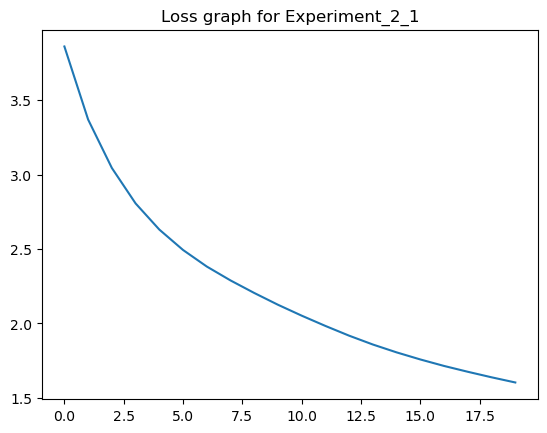

In [23]:
import json
with open(f'{model_path}/{model_id}/loss.json', 'r') as f:
    loss = json.loads(f.read())
plt.figure()
plt.title(f"Loss graph for {experiment_id}")
plt.plot(loss['loss'], label="loss")
plt.show()

# Quick validation set-up

Choose a trajectory from the dataset.
Visualize trajectory
use model to predict the same trajectory ( but in fewer steps! )
compare the 2 trajectory plots
# todo compare the loss or something
# todo save results of validation

In [24]:
dataset_to_predict = '72'
dataset_to_predict = '18'
x, y, vx, vy = tbp_util.load_dataset(dataset_to_predict)
print(x.shape)

(250000, 3)


In [25]:
length_to_predict = int(x.shape[0] / prediction_offset)
print(
    f"The original trajectory is T={x.shape[0]} time steps long, so we have to predict T/prediction_offset={x.shape[0]}/{prediction_offset}={length_to_predict} steps because we predict {prediction_offset} steps into the future.")

The original trajectory is T=250000 time steps long, so we have to predict T/prediction_offset=250000/10=25000 steps because we predict 10 steps into the future.


In [26]:
limit = length_to_predict
y_pred = np.zeros((limit, 12), dtype=np.float64)
y_pred[0,] = np.concatenate((x[0,], y[0,], vx[0,], vy[0,]))

In [27]:
for i in range(limit - 1):
    prediction = model(y_pred[i,].reshape(1, 12), training=False).numpy()

    # convert the delta's to an actual prediction
    prediction /= scaling_factor
    prediction = y_pred[i,].reshape(1, 12) - prediction

    # stop early when the system gets out of bounds
    if np.min(prediction[0, :6]) < -3 or np.max(prediction[0, :6]) > 3 or np.min(prediction) < -20 or np.max(
            prediction) > 20:
        print(f"Stop predicting at t={i * prediction_offset} ({i} steps) after encountering {prediction}")
        break

    y_pred[i + 1,] = prediction

Stop predicting at t=92090 (9209 steps) after encountering [[  1.97109866  -1.13112481  -1.03048921  -2.32404128   3.0007027
   -0.60290634   8.54739678  -5.46467752  -3.78049823 -10.42351957
   11.75876743  -1.09557964]]


In [32]:
y_pred2 = y_pred[:i]

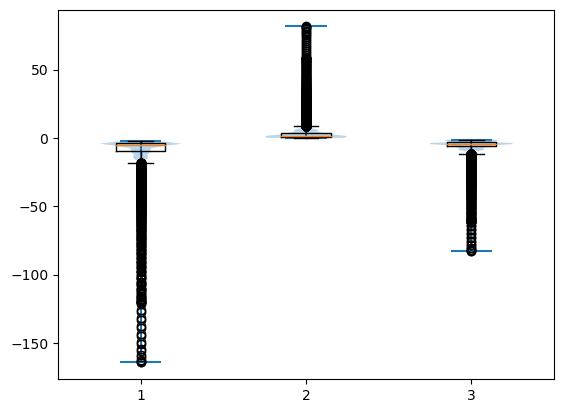

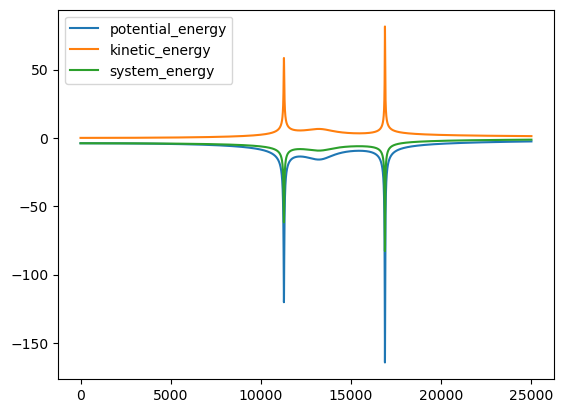

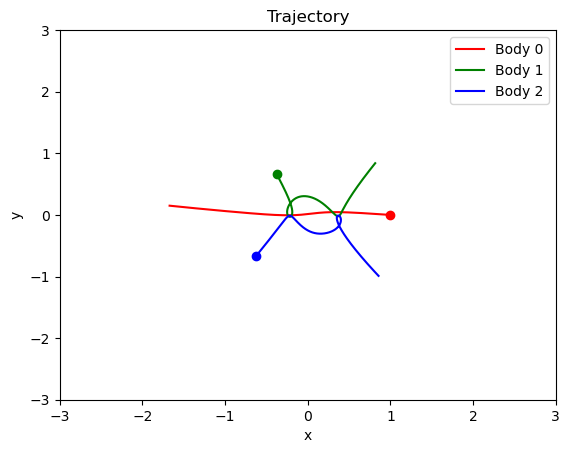

In [33]:
# Real trajectory
visualize_dataset(*tbp_util.load_dataset(dataset_to_predict), G, M, down_sample_factor=prediction_offset)

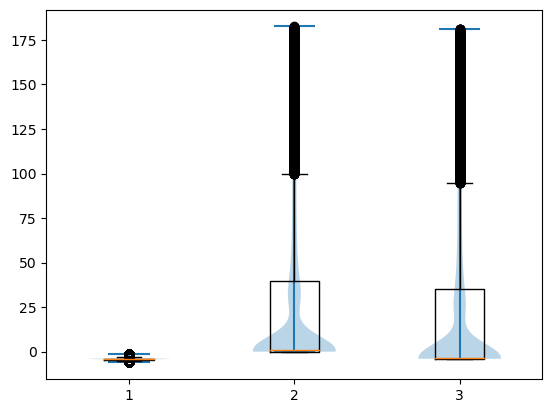

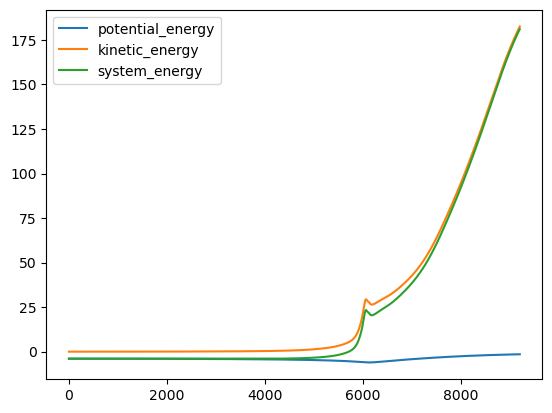

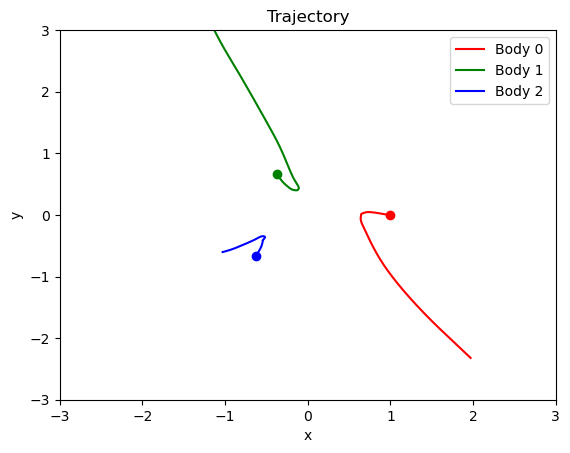

In [34]:
# Predicted trajectory
pred_x, pred_y, pred_vx, pred_vy = np.hsplit(y_pred2, 4)
visualize_dataset(pred_x, pred_y, pred_vx, pred_vy, G, M, down_sample_factor=1)

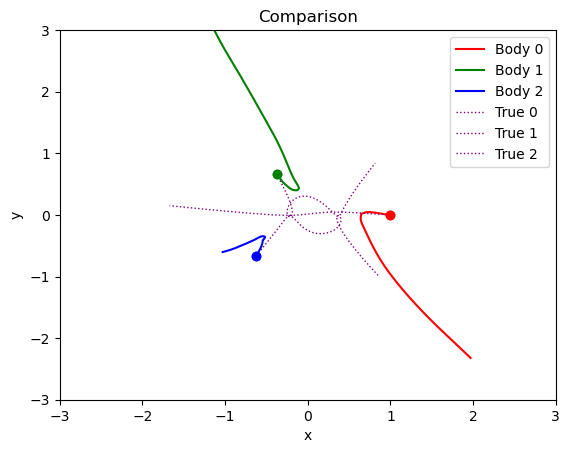

In [35]:
import Three_body_2D_Rick

# Comparison plot
true_x, true_y, _, _ = tbp_util.load_dataset(dataset_to_predict)
Three_body_2D_Rick.compare_plot(true_x, true_y, pred_x, pred_y)